In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import pickle
from numba import njit
import psycopg2
import psycopg2.extras
from psycopg2 import sql
from itertools import product
from datetime import timedelta, datetime
from skimage.filters import threshold_minimum, threshold_mean
from scipy import stats
from scipy.stats import norm
import matplotlib.dates as mdates
from tqdm import tqdm_notebook
import os

from distributed import worker_client

import bb_utils
import bb_utils.meta
from bb_utils.ids import BeesbookID
import bb_backend
from bb_backend.api import FramePlotter, VideoPlotter
from bb_backend.api import get_plot_coordinates, transform_axis_coordinates, get_image_origin

bb_backend.api.server_adress = '127.0.0.1:8000'

sns.set()

/usr/local/lib/python3.5/dist-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [3]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from datetime import timedelta, datetime, time

# https://github.com/nebw/data_utils
# from data_utils.visualization import bivariate_kdeplot

# https://github.com/BioroboticsLab/bb_utils
import bb_utils
import bb_utils.meta
import bb_utils.ids

# https://github.com/BioroboticsLab/beesbook_backend
import bb_backend
from bb_backend.api import get_plot_coordinates, get_image_origin

import seaborn as sns
def setSnsStyle(style):
    sns.set(style=style, font_scale=1.5)
    font = {'family' : 'serif',
       'weight' : 'normal',
       'size'   : 36}
    matplotlib.rc('font', **font)
    matplotlib.rcParams['xtick.labelsize'] = 16
    matplotlib.rcParams['ytick.labelsize'] = 16
    matplotlib.rcParams['axes.titlesize'] = 16
    matplotlib.rcParams['axes.labelsize'] = 16
   
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

setSnsStyle("ticks")

In [4]:
connect_str = """dbname='beesbook' 
                 user='reader' 
                 host='tonic.imp.fu-berlin.de' 
                 password='' 
                 application_name='sammelgruppen'"""

In [5]:
meta = bb_utils.meta.BeeMetaInfo()

In [6]:
def transform_axis_coordinates(x, y, cam_id=None, year=2016):
    origin = get_image_origin(cam_id, year)
    if origin[0] == 1:
        x = 3000 - x
    if origin[1] == 0:
        y = 4000 - y
    return x, y

In [7]:
#group_indices = (21, 8, 22, 23)
group_indices = (11, 8, 23, 20) 

In [8]:
group_idx = group_indices[0]

group_ids = map(lambda i: i.as_ferwar(), 
                list(map(bb_utils.ids.BeesbookID.from_dec_12, meta.get_foragergroup(group_idx).dec12)))
group_ids = list(group_ids)

In [9]:
group_ids

[769, 1593, 319, 337, 1362, 1122, 885, 392, 648, 199, 2031]

In [10]:
meta.get_foragergroup(group_idx)

group_id                                                   11
date                                      2016-08-10 00:00:00
location                                                F1-F2
dec12       [27, 918, 1017, 1297, 1325, 1572, 1883, 2185, ...
Name: 10, dtype: object

In [11]:
with psycopg2.connect(connect_str) as conn:
    with conn.cursor() as cur:
        cur.execute("""SET geqo_effort to 10""")
        cur.execute("""SET max_parallel_workers_per_gather TO 12;""")
        cur.execute("""DROP MATERIALIZED VIEW IF EXISTS ben_subset;""")
        cur.execute("""
            CREATE MATERIALIZED VIEW ben_subset AS
               SELECT * FROM bb_detections A
               WHERE
                   A.timestamp >= %s
                   AND A.timestamp <= %s
                   AND A.bee_id_confidence >= %s;""",
            (meta.get_foragergroup(group_idx).date,
             meta.get_foragergroup(group_idx).date + timedelta(hours=24),
             .9))
        cur.execute("""CREATE INDEX idx_subset_ts_bee_id_ben on ben_subset (timestamp, bee_id);""")

In [12]:
def get_interactions(ts_start, ts_end, max_dist=212.):   
    connect_str = """dbname='beesbook' 
                     user='reader' 
                     host='tonic.imp.fu-berlin.de' 
                     password='' 
                     application_name='sammelgruppen'"""
    
    query = """
    SELECT * FROM (
       SELECT A.bee_id, A.detection_idx, B.bee_id, B.detection_idx, (|/((A.x_pos - B.x_pos) ^ 2 + (A.y_pos - B.y_pos) ^ 2)) as distance,
               A.frame_id, A.cam_id, A.timestamp, A.x_pos as a_x, A.y_pos as a_y,
               B.x_pos as B_x, B.y_pos as b_y
       FROM ben_subset A
       INNER JOIN ben_subset B ON A.frame_id = B.frame_id
       WHERE
           A.bee_id in %s
           AND B.bee_id in %s
           AND A.timestamp >= %s
           AND A.timestamp <= %s
           AND B.timestamp >= %s
           AND B.timestamp <= %s
           AND A.bee_id < B.bee_id
       ) _subquery
    WHERE distance < %s
    ORDER BY timestamp ASC;"""
    
    with psycopg2.connect(connect_str) as conn:
        with conn.cursor() as cur:
            cur.execute("""SET geqo_effort to 10""")
            cur.execute("""SET max_parallel_workers_per_gather TO 1;""")

            interaction_df = pd.read_sql_query(
                query, conn, 
                params=(tuple(group_ids), tuple(group_ids),
                        ts_start, ts_end,
                        ts_start, ts_end,
                        max_dist),
                coerce_float=False)
            
    return interaction_df

In [13]:
with psycopg2.connect(connect_str) as conn:
    all_ids = pd.read_sql_query(
        """SELECT bee_id, COUNT(*) from ben_subset GROUP BY bee_id;""", conn)

In [14]:
all_ids.shape

(1737, 2)

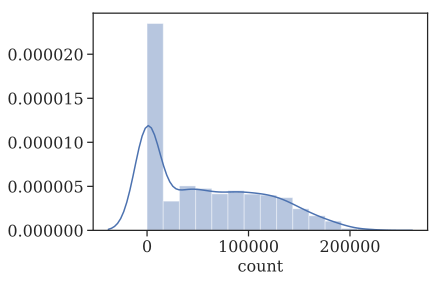

In [15]:
sns.distplot(all_ids['count'])

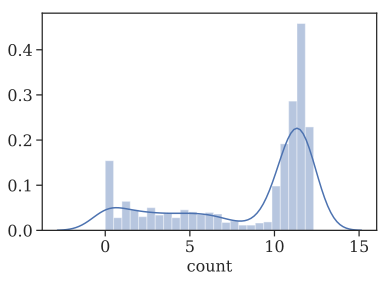

In [16]:
sns.distplot(np.log(all_ids['count']), bins=25)

In [17]:
ages = np.array(list(map(lambda i: meta.get_age(i, meta.get_foragergroup(group_idx).date).days, 
                map(BeesbookID.from_ferwar, all_ids.bee_id))))

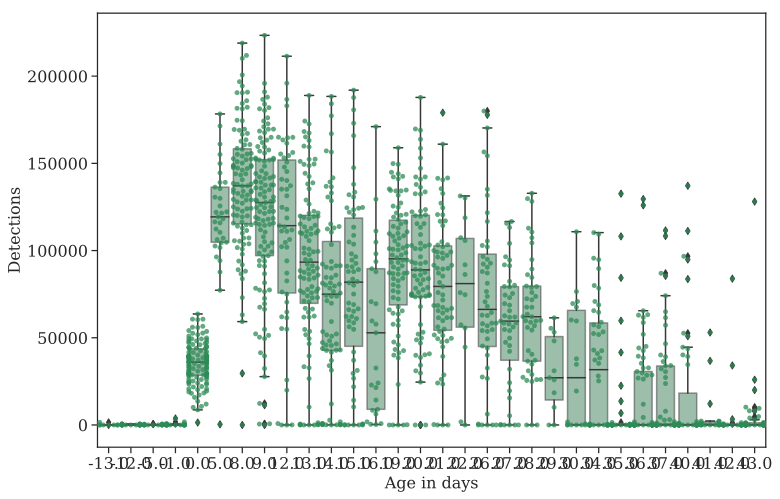

In [18]:
plt.figure(figsize=(12, 8))
sns.swarmplot(ages, all_ids['count'].values, color="seagreen", alpha=.75)
ax = sns.boxplot(ages, all_ids['count'].values, color="seagreen")
_ = plt.setp(ax.artists, alpha=.5)
plt.xlabel('Age in days')
_ = plt.ylabel('Detections')

In [19]:
alive_threshold = np.exp(threshold_mean(np.log(all_ids['count'][:, None])))

In [20]:
#alive_threshold = all_ids['count'].values[is_dead].max()

In [21]:
is_dead = [a < alive_threshold for a in all_ids['count'].values]
is_dead |= np.array([np.isnan(a) or a < 0 for a in ages])
is_alive = np.logical_not(is_dead)

In [22]:
import seaborn as sns
import matplotlib
def setSnsStyle(style):
    sns.set(style=style, font_scale=1.5)
    font = {'family' : 'serif',
       'weight' : 'normal',
       'size'   : 16}
    matplotlib.rc('font', **font)
    matplotlib.rcParams['xtick.labelsize'] = 16
    matplotlib.rcParams['ytick.labelsize'] = 16
    matplotlib.rcParams['axes.titlesize'] = 16
    matplotlib.rcParams['axes.labelsize'] = 16
   
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
#%config InlineBackend.figure_format = 'retina'

setSnsStyle("ticks")

FileNotFoundError: [Errno 2] No such file or directory: '/home/ben/ssh/zedat-web/interactions/ages-11.png'

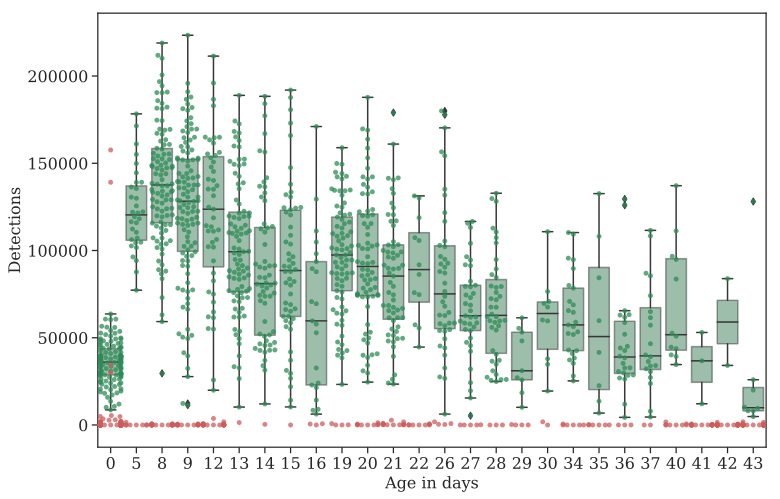

In [23]:
fig = plt.figure(figsize=(12, 8))
sns.swarmplot(ages[is_alive].astype(np.int), all_ids['count'].values[is_alive], 
              color="seagreen", alpha=.75)
sns.swarmplot(ages[is_dead].astype(np.int), all_ids['count'].values[is_dead], 
              color="indianred", alpha=.75)
ax = sns.boxplot(ages[is_alive].astype(np.int), all_ids['count'].values[is_alive], 
                 color="seagreen")
_ = plt.setp(ax.artists, alpha=.5)
plt.xlabel('Age in days')
_ = plt.ylabel('Detections')
fig.savefig('/home/ben/ssh/zedat-web/interactions/ages-{}.png'.format(group_idx),
            bbox_inches='tight', pad_inches=0, dpi=300)

In [ ]:
np.count_nonzero(is_alive), np.count_nonzero(is_dead)

In [ ]:
plt.figure(figsize=(12, 8))
sns.distplot(ages[is_alive], kde=False, fit=stats.halfnorm, bins=10, 
             fit_kws={'label': 'Half-normal distribution fit'})
plt.xlim(0, max(ages[is_alive]) + 10)
plt.legend()
_ = plt.title('Age distribution')
plt.savefig('/home/ben/ssh/zedat-web/interactions/agedist-{}.png'.format(group_idx),
            bbox_inches='tight', pad_inches=0, dpi=300)

In [ ]:
date = meta.get_foragergroup(group_idx).date

In [ ]:
sorted_indices = np.argsort(ages)

In [ ]:
all_ids = all_ids.loc[sorted_indices]

In [ ]:
is_alive = is_alive[sorted_indices]
is_dead = is_dead[sorted_indices]
ages = ages[sorted_indices]

In [ ]:
alive_ids = set(all_ids.bee_id.values[is_alive])
np_alive_ids = np.array(all_ids.bee_id.values[is_alive])
num_alive = np.count_nonzero(is_alive)

In [ ]:
interaction_df = get_interactions(date + timedelta(hours=7), date + timedelta(hours=19))

In [ ]:
interaction_df.head()

In [ ]:
id_lookup = np.zeros(2 ** 12, dtype=np.int64)
for seq_id, bee_id in enumerate(np_alive_ids):
    id_lookup[bee_id] = seq_id

In [ ]:
def transform_axis_coordinates(x, y, cam_id=None, year=2016):
    origin = get_image_origin(cam_id, year)
    if origin[0] == 1:
        x = 3000 - x
    if origin[1] == 0:
        y = 4000 - y
    return x, y

In [ ]:
def plot_spatial_distribution(data, cam_ids, ax, max_sample_size=10000, bw=150):   
    xs = []
    ys = []
    cs = []
    ids = []
    cam_data = pd.concat([data[data.cam_id == c] for c in cam_ids])
    if len(cam_data) > 0:
        cam_data = cam_data.sample(min(max_sample_size, len(cam_data)))
        for cam_id in cam_ids:
            if np.sum(data.cam_id.values == cam_id) > 0:
                data_subset = cam_data[cam_data.cam_id==cam_id].copy()
                x, y = get_plot_coordinates(data_subset.a_x, data_subset.a_y)
                x, y = transform_axis_coordinates(x, y, cam_id)
                if (cam_id % 2) != 0:
                    x += 3000
                xs += list(x)
                ys += list(y)
                cs += list(data_subset.bee_id.iloc[:, 0].map(id_map).values)

                x, y = get_plot_coordinates(data_subset.b_x, data_subset.b_y)
                x, y = transform_axis_coordinates(x, y, cam_id)
                if (cam_id % 2) != 0:
                    x += 3000
                xs += list(x)
                ys += list(y)
                cs += list(data_subset.bee_id.iloc[:, 1].map(id_map).values)

    x = xs
    y = ys
    c = cs
    
    bivariate_kdeplot(x, y, None, (0, 6000), (0, 4000), bw=.3, ax=ax, 
                      contourf_kws={'cmap': 'Greys', 'alpha': 0.5},
                      scatter_kws={'c': [colors[i] for i in c], 'alpha': .75,
                                   'edgecolors': 'none', 's': 10})

In [ ]:
def plot_spatial_wrapper(data, side, group_idx, ax, fig, max_sample_size=10000):
    assert side in ('right', 'left')
    cam_ids = (0, 1) if side == 'right' else (2, 3)
    plot_spatial_distribution(data, cam_ids, ax, max_sample_size=max_sample_size)
    if side == 'right':
        ax.arrow(6000-250, 150, 100, 0, fc="k", ec="k",
                  head_width=25, linewidth=10)
    else:
        ax.arrow(250, 150, -100, 0, fc="k", ec="k",
                  head_width=25, linewidth=10)
    ax.set_title('{} comb side'.format(side))

In [ ]:
idxs = np.array([id_lookup[i] for i in group_ids])

In [ ]:
group_ids = set(group_ids)

In [ ]:
interaction_df.cam_id.unique()

In [ ]:
group_interactions = interaction_df[np.logical_and(
    interaction_df.bee_id.iloc[:, 0].isin(group_ids).values,
    interaction_df.bee_id.iloc[:, 1].isin(group_ids).values
)]

In [ ]:
group_interactions.cam_id.unique()

In [ ]:
id_map = {}
for idx, bee_id in enumerate(np.unique(np.concatenate([group_interactions.bee_id.iloc[:, 0], group_interactions.bee_id.iloc[:, 1]]))):
    id_map[bee_id] = idx


In [ ]:
colors = [plt.cm.Set2(float(i) / len(id_map)) for i in range(len(id_map))]

In [ ]:
fig, axes = plt.subplots(nrows=2, figsize=(10, 14))

plot_spatial_wrapper(group_interactions, 'right', group_idx, 
                     axes[0], fig, max_sample_size=1000)
plot_spatial_wrapper(group_interactions, 'left', group_idx,
                     axes[1], fig, max_sample_size=1000)

colors = [plt.cm.Set2(float(i)/len(id_map)) for i in range(len(id_map))]
for bee_id, c_idx in id_map.items():
    axes[0].scatter(-1, c_idx, c=colors[c_idx], label=str(bee_id), 
                    edgecolors='none')
axes[0].legend(loc='upper right')

fig.suptitle('Forager group {} interactions ({}) - {}'.format(
    group_idx, meta.get_foragergroup(group_idx).date.date(), 'during daytime'), 
    fontsize=18)

fig.tight_layout(rect=[0, 0.03, 1, 0.985])



plt.show()
#plt.savefig(os.path.join('/home/ben/ssh/zedat-web/heatmaps_foragers/interactions_group_{}_{}.png'.format(
#     group_idx, 'day')))
